In [ ]:
#Imports done to reduce headspace
import os
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
import pymysql
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [ ]:
#CSVs declared as a list to make handling easier
csv_file_list = ["csv_file_folder\customers.csv","csv_file_folder\Orders.csv", "csv_file_folder\inventory.csv", "csv_file_folder\order_items.csv", "csv_file_folder\products.csv", "csv_file_folder\suppliers_data.csv"]

In [3]:
#load data from csv file list
def load_data(csv_file_list):
    data_frames = []
    for i in csv_file_list:
        data_frame = pd.read_csv(i)
        data_frames.append(data_frame)
    return data_frames

In [4]:
#Clean, add columns, remove replications, type changes, add new columns

def prepare_data(data_frames):
    prepared_data_frames = []
    data_frames = load_data(csv_file_list)
    for df in data_frames:
        df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})
        prepared_data_frames.append(df)
    return prepared_data_frames

In [ ]:

'''1. price of a product exists in the product table but quantity exists in the order table
In order to sum the orders per order, both tables need to be merged

2. Converted order_date to datetime and created three separate columns for year month and day'''



def prepare_data2(data_frames):
    data_frames = prepare_data(data_frames)
    order_df = data_frames[1]
    products_df = data_frames[4]
    merged_df = pd.merge(order_df, products_df, on = 'product_id')
    order_df["order_sum"] = np.multiply(merged_df['quantity'], merged_df['price'])

    order_df = data_frames[1]
    order_df['order_date'] = pd.to_datetime(order_df['order_date'], format='%m/%d/%Y')
    order_df['year'] = order_df['order_date'].dt.year
    order_df['month'] = order_df['order_date'].dt.month
    order_df['day'] = order_df['order_date'].dt.day

    data_frames[0]['join_date'] = pd.to_datetime(data_frames[0]['join_date'])
    data_frames[1] = data_frames[1].rename(columns= {'Cutomer_id':'customer_id'})
    return data_frames


In [ ]:
#look at how my list of dataframes is structured

df_list1 = load_data(csv_file_list)
df_list2 = prepare_data(df_list1)
order_df2 = prepare_data2(df_list2)


for n in order_df2:
    print(n.info())
print(len(order_df2))

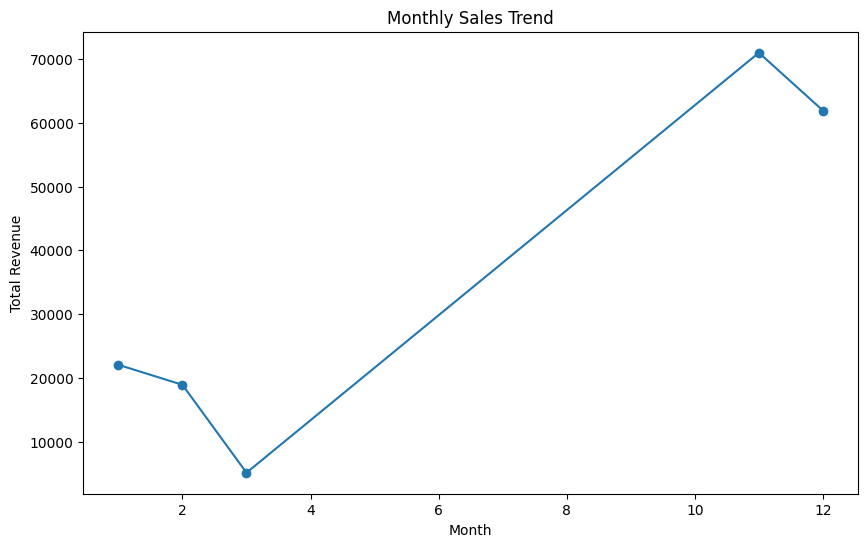

In [7]:
def sales_per_month_plot():
    # Group by the 'year_month' and sum the 'total_revenue'
    monthly_sales = order_df2[1].groupby('month')['order_sum'].sum()

# Plot the monthly sales trend
    monthly_sales.plot(kind='line', marker='o', figsize=(10, 6), title='Monthly Sales Trend')

# Label the axes
    plt.xlabel('Month')
    plt.ylabel('Total Revenue')

# Display the plot
    plt.show()
sales_per_month_plot()

In [ ]:
# Connect to database
connection = mysql.connector.connect()
def connect_to_database():
    db_params={

            'host': os.getenv('HOST'),
            'user': os.getenv('USER_NAME'),
            'password':os.getenv("PASSWORD"),
            'database': os.getenv('NAME')
            
    }
    print(db_params)
    if connection.is_connected:
        print("Database connected")

connect_to_database()

In [ ]:

host = os.getenv('HOST')
user = os.getenv('USER_NAME')
password = os.getenv('PASSWORD')
db_name = os.getenv('DB_NAME')


In [ ]:
#One final look at my dataframes for database population
for dataframe in order_df2:
    dataframe.head(20)
    dataframe.info()

In [ ]:
#populate database using pymysql and sqlalchemy
#sqlalchemy has stopgaps against sql injection as well as other security layers
pymysql.install_as_MySQLdb()
engine = create_engine(f"mysql+pymysql://{os.getenv('USER_NAME')}:{os.getenv('PASSWORD')}@{os.getenv('HOST')}:3306/{os.getenv('DB_NAME')}")
order_df2[0].to_sql('customer', con=engine, if_exists='replace', index=False)
order_df2[1].to_sql('orders', con=engine, if_exists='replace', index=False)
order_df2[2].to_sql('inventory', con=engine, if_exists='replace', index=False)
order_df2[3].to_sql('order_items', con=engine, if_exists='replace', index=False)
order_df2[4].to_sql('products', con=engine, if_exists='replace', index=False)
order_df2[5].to_sql('suppliers_data', con=engine, if_exists='replace', index=False)



670